In [1]:
from gensim import models

from IPython.display import display, HTML

Couldn't import dot_parser, loading of dot files will not be possible.


In [64]:
m = models.word2vec.Word2Vec.load("models/word2vec/skipgram/model.txt")
#m = models.word2vec.Word2Vec.load("models/word2vec/cbow/model.txt")

In [65]:
questions = [ "philosophy", "science", "religion", "knowledge", "wisdom", "love" ]

partitions = [ [["philosophy"],[]],
              [["continental_philosophy"],["analytic_philosophy"]],
              [["analytic_philosophy"],["continental_philosophy"]]]

In [66]:
def print_questions(answers):
    html = "<table>"

    html += """
    <tr>
      <td></td>
      <th>philosophy</th>
      <th>continental philosophy</th>
      <th>analytic philosophy</th>
    </tr>
    """
    
    for question, control, analytic, continental in answers:
        html += "<tr><td style=\"width: 100px; text-align: center; \"><h3>%s</h3></td>" % question
        html += "<td><ul>"
        html += "\n".join([ "<li>%s</li>" % word for word, score in control ])
        html += "</ul></td>"
        html += "<td><ul>"
        html += "\n".join([ "<li>%s</li>" % word for word, score in analytic ])
        html += "</ul></td>"
        html += "<td><ul>"
        html += "\n".join([ "<li>%s</li>" % word for word, score in continental ])
        html += "</ul></td>"
        html += "</tr>"
    
    html += "</table>"

    display(HTML(html))

def q(positive, negative, model):
  try:
    result = model.most_similar(positive=positive, negative=negative)
  except:
    result = []
  
  return result

print_questions([ ([question]+[ q(p[0]+[question], p[1], m) for p in partitions]) for question in questions ])

,philosophy,continental philosophy,analytic philosophy
philosophy,analytic_philosophy philosophy_mind aesthetics moral_philosophy ordinary_language philosophy_religion key_themes epistemology music_poetry metaphysics,aesthetics contemporary_philosophy existentialism deleuze_derrida hermeneutics key_themes deconstruction poetics cultural_criticism ethics_politics,philosophy_mind ordinary_language logic philosophy_science moral_philosophy logic_metaphysics social_science stanford_encyclopedia philosophy_language social_epistemology
science,philosophy_science philosophy_religion religion_science social_science analytic_philosophy natural_science metaphysics natural_sciences view_positivism sciences,technology science_technology arts occidental sciences architecture postmodern museum_contemporary museums chinese_astronomy,sciences philosophy_science physics mathematics natural_sciences logic space_time set_theory religion_science application
religion,history_religions philosophy_religion metaphysics religion_ethics contemporary_philosophy moral_philosophy judaism kantian_philosophy analytic_philosophy views_emerging,history_religions orthodox_judaism judaism religions spirituality religion_ethics mormonism cosmopolitanism school_sport spiritualism,history_religions belief_god christianity religious_belief philosophy_religion rationality deism relationship_religion divinity faith
knowledge,natural_science epistemology theory_knowledge metaphysics analytic_philosophy natural_sciences philosophy_mathematics mou nature_universe religious_belief,imagination vast shamanism japanese_culture after_auschwitz tracing vedas eroticism insights ancient_wisdom,human_knowledge reasoning predicate thought_experiment inference set_theory completeness natural_science first-order_logic intuition
wisdom,vedas gnosis lewis_rumi love_wisdom divine_wisdom morals asceticism cynicism nature_universe fons_vitae,spirituality mystics piety satori ancient_wisdom shiva fons_vitae ecstasy mystic norse,goodness vedas deity virtue righteousness divine_human godhead revelation holy_scriptures divine_wisdom
love,ecology_spirituality love_wisdom love? eroticism greek_tragedy without_guilt fragility_goodness social_epistemology eros bodies_matter,erotic eros passion beauty ghosts desire compassion visions kindness goddess,affection goodness joy man_woman sex potion kindness virtuous abides my_brother


In [67]:
import numpy as np

In [68]:
A_question = np.array([ m[question] for question in questions ])

In [69]:
A_philosophy = reduce(lambda a,b: a+b, [ q(["philosophy", m[question]], [], m) for question in questions ])
A_philosophy = np.array([ m[w] for w,s in A_philosophy ])

In [70]:
A_continental = reduce(lambda a,b: a+b, [ q(["continental_philosophy", m[question]], ["analytic_philosophy"], m) for question in questions ])
A_continental = np.array([ m[w] for w,s in A_continental ])

In [71]:
A_analytic = reduce(lambda a,b: a+b, [ q(["analytic_philosophy", m[question]], ["continental_philosophy"], m) for question in questions ])
A_analytic = np.array([ m[w] for w,s in A_analytic ])

## Principal Component Analysis

In [72]:
from sklearn.decomposition import PCA

In [73]:
pca = PCA(n_components=2)

A = np.append(A_question, A_philosophy, axis=0)
A = np.append(A, A_continental, axis=0)
A = np.append(A, A_analytic, axis=0)

pca = pca.fit(A)

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull

In [75]:
s1 = partitions[0] + [ ".70" ]
s2 = partitions[1] + [ "red" ]
s3 = partitions[2] + [ "blue" ]

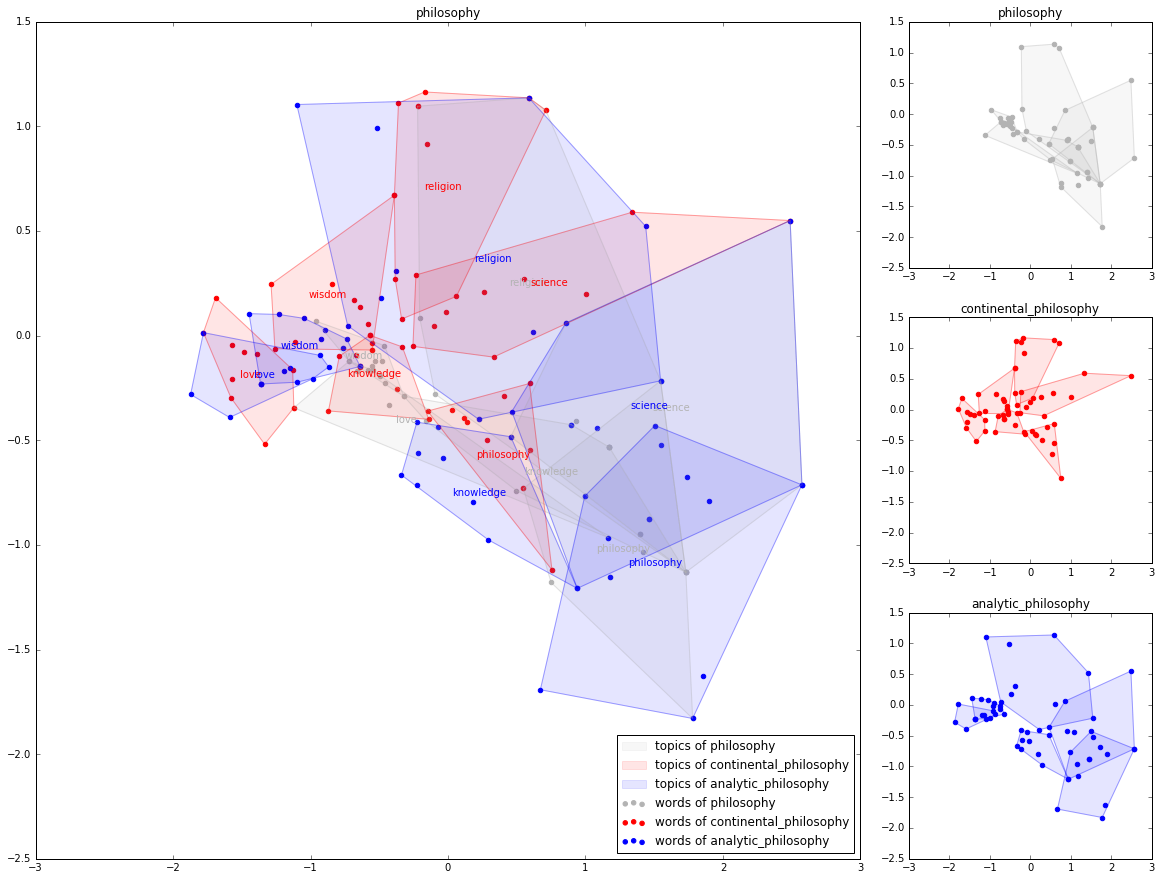

In [76]:
def plot_words(ax, s, label=False, legend=False):
  
  ax.set_title(s[0][0][0])
  
  s = [ (p+[question],n,c) for (p,n,c) in s for question in questions  ]
  
  points_label = {}
  groups = {}
  
  for p, n, c in s:
    Z = pca.transform(np.array([ m[w] for w,s in q(p,n,m) ]))

    hull = ConvexHull(Z)

    for simplex in hull.simplices:
      ax.plot(Z[simplex, 0], Z[simplex, 1], '-', color=c, alpha=0.3)

    simplex_x, simplex_y = ([], [])

    for simplex in hull.vertices:
      simplex_x.append(Z[simplex, 0])
      simplex_y.append(Z[simplex, 1])

    if label:
      ax.text(np.mean(simplex_x), np.mean(simplex_y), p[1], color=c, horizontalalignment='center', verticalalignment='center',)
      
    groups[p[0]] = ax.fill(simplex_x, simplex_y, '', color=c, alpha=0.1)

    Z_ = zip(*Z)
    
    points_label[p[0]] = ax.scatter(Z_[0], Z_[1], lw=1, color=c)

  if legend:
    ax.legend([ v[0] for v in groups.values() ] \
                + [ v for v in points_label.values() ],\
              [ "topics of %s" % k for k in groups.keys() ]\
                + [ "words of %s" % k for k in points_label.keys() ],\
             loc='lower right')

fig = plt.figure(figsize=(20,15))

ax1 = plt.subplot2grid((3,4), (0, 0), rowspan=3, colspan=3)
ax2 = plt.subplot2grid((3,4), (0, 3), sharex=ax1, sharey=ax1)
ax3 = plt.subplot2grid((3,4), (1, 3), sharex=ax1, sharey=ax1)
ax4 = plt.subplot2grid((3,4), (2, 3), sharex=ax1, sharey=ax1)
        
plot_words(ax1, [s1]+[s2]+[s3], label=True, legend=True)
plot_words(ax2, [s1])
plot_words(ax3, [s2])
plot_words(ax4, [s3])


plt.show()

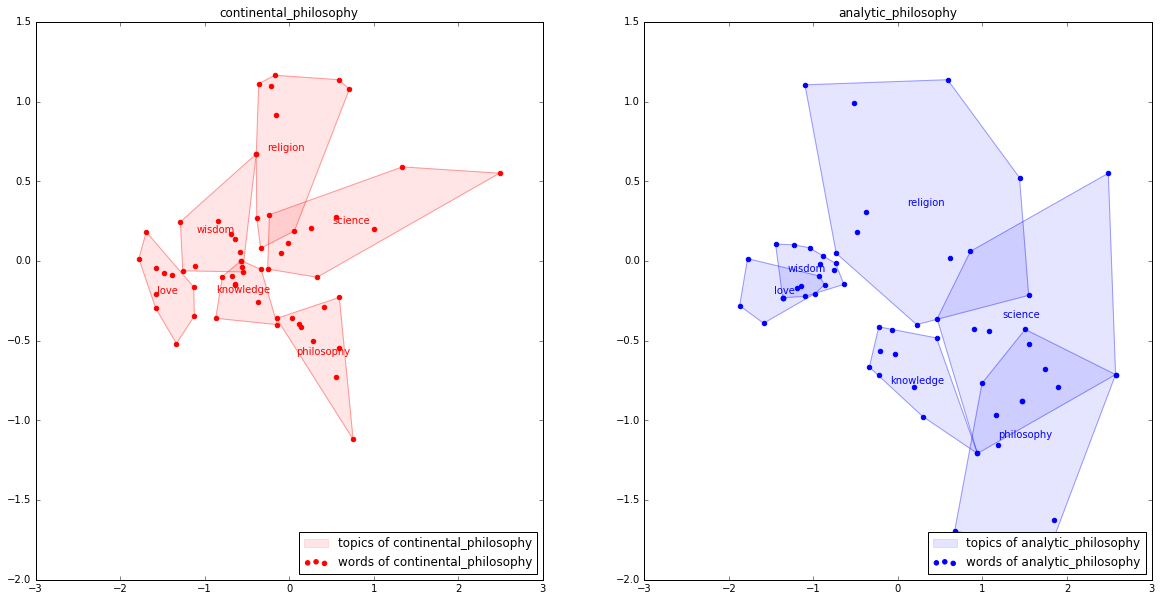

In [77]:
fig = plt.figure(figsize=(20,10))

ax1 = plt.subplot2grid((1,2), (0, 0))
ax2 = plt.subplot2grid((1,2), (0, 1), sharex=ax1, sharey=ax1)

plot_words(ax1, [s2], label=True, legend=True)
plot_words(ax2, [s3], label=True, legend=True)

plt.show()